# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:

$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

importaciones

In [34]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')
from gensim.sklearn_api import tfidf

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import math
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor
#xgb
import xgboost as xgb

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()


import spacy
# para activar este ultimo escribir en consola "python -m spacy download en_core_web_sm"
from spacy.lang.fi import Finnish
import en_core_web_sm

inicio de csv

In [3]:
tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_original_prueba = pd.read_csv('test.csv',index_col=['id'])
tweets_original_prueba.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


calculo resultado

In [5]:
#resultados
resultados_de_test = pd.read_csv('respuestas.csv',index_col=['id'])
#revisar los resultados
def calclarPresicionYRecall(df):
    respuestas = pd.read_csv('respuestas.csv',index_col=['id'])
    respuestas['prediccion'] = df['target']
    #respuestas['TP'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FP'] = [1 if (respuestas['target'] == 0 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FN'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 0) else 0]
    
    respuestas.loc[respuestas['prediccion'] + respuestas['target'] == 2 , 'TP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 1 , 'FP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 2 , 'FN'] = 1
    respuestas['TP'].fillna(0, inplace=True)
    respuestas['FP'].fillna(0, inplace=True)
    respuestas['FN'].fillna(0, inplace=True)

    tp = respuestas['TP'].sum()
    fp = respuestas['FP'].sum()
    fn = respuestas['FN'].sum()
    
    #print(tp,fp,fn)
    #print(respuestas.head())
    
    sumaPresicion = tp + fp
    sumaRecall = tp + fn
    presicion = tp / sumaPresicion
    recall = tp / sumaRecall
    return (presicion,recall)

def F1(df):
    presicion,recall = calclarPresicionYRecall(df)
    resultado = 2 * presicion * recall
    resultado /= (presicion + recall)
    return resultado

In [6]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

inicio de problema

## CATBOOST

In [7]:
#esto deberia ahorrar columnas al hacer un BOW
def digitos_en_binario(numero):
    logaritmo2 = math.log2(numero)
    entero = int(logaritmo2)
    entero += 1
    return entero

def transformar_a_vector_binario(numero,digitos):
    nBinario = aBinario(numero)
    digit = len(nBinario)
    while (digit < digitos):
        digit = len(nBinario)
        nBinario.insert(0,0)
    return nBinario

def aBinario(numero):
    numeroDecimal = numero
    numeroBinario = []
    if (numeroDecimal < 2):
        numeroBinario.append(numeroDecimal)
        return numeroBinario
    while numeroDecimal >=2:
        numeroBinario.append(numeroDecimal % 2)
        numeroDecimal //= 2
    numeroBinario.append(numeroDecimal)
    numeroBinario.reverse()
    return numeroBinario

#PRUEVA
#if (digitos_en_binario(63) != 6):
#    print("error en digitos_en_binario")
#bina = aBinario(64)
#if (bina != 6 and bina[0] != 1 and bina[1] != 0 and bina[2] != 0 and bina[3] != 0 and bina[4] != 0 and bina[5] != 0):
#    print("error en aBinario")
#print(transformar_a_vector_binario(64,8))
#TODO OK

In [8]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [9]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    contador = 0
    for palabra in listado:
        if (palabra[0] == '#'):
            contador += 1
    return contador

def str_hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    for palabra in listado:
        if (palabra[0] == '#'):
            return palabra
    return ""

def cantidad_de_palabras_en_texto(lista,palabra):
    contador = 0
    for elemento in lista:
        if (elemento == palabra):
            contador += 1
    return contador

def localizacion(x,lista):
    if (x == ""):
        return 0
    for i in range(len(lista)):
        palabra = lista[i]
        if (palabra == x):
            return (i + 1)
    return 0

def ubicacionEnLista(x,pos):
    return x[pos]

def BOW_locacion(df,lista,columna):
    cantidadDePalabras = len(lista)
    if (cantidadDePalabras == 0):
        return df
    binarioMaximo = cantidadDePalabras + 1
    digitosBinario = digitos_en_binario(binarioMaximo)
    #for i in range(digitosBinario):
    #    df["palabra_{}".format(i)] = 0
    #df['location'] = df['location'].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    #for j in range(digitosBinario):
    #    df["loc_palabra_{}".format(j)] = df['location'].map(lambda x: ubicacionEnLista(x,j))
    df[columna] = df[columna].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    for j in range(digitosBinario):
        df["{}_palabra_{}".format(columna,j)] = df[columna].map(lambda x: ubicacionEnLista(x,j))
    return df


In [10]:
def eliminar_signos(texto):
    palabra = ""
    for caracter in texto:
        if (caracter < 'a' or caracter > 'z'):
            continue
        palabra += caracter
    return palabra

In [11]:
def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['keyword'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    df['cantidad_de_hashtag_en_texto'] = df['palabras_de_texto'].map(hashtag_en_tweet)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    #Se requiere pensarlo mas
    #cantidadDePalabrasDelTexto = len(listadoDePalabrasDelTextoDelSetDeEntrenamiento)
    #for i in range(cantidadDePalabrasDelTexto):
    #    df["palabra_{}".format(i)] = 0
    
    df = letra_inicial_Keyword_BOW(df)
    
    #repetir el proceso habiendo calculado los hashtag
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [eliminar_signos(item) for item in x])
    
    for palabra in listadoDePalabrasDelTextoDelSetDeEntrenamiento:
        df[palabra] = df['palabras_de_texto'].map(lambda x: cantidad_de_palabras_en_texto(x,palabra))
    
    df = BOW_locacion(df,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,'location')
    df = BOW_locacion(df,listadoDePalabrasDelKeywordDelSetDeEntrenamiento,'keyword')
    #hashtag (no eleva la metrica)
    #df['hashtag_en_texto'] = df['palabras_de_texto'].map(str_hashtag_en_tweet)
    #df = BOW_locacion(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento,'hashtag_en_texto')
    #df = df.drop(columns=['hashtag_en_texto'])
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = TfidfVectorizer.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #for col in df_tfidf.columns():
    #    df = df.join(df_tfidf[col])
    #df.join(df_tfidf)#mal planteado
    
    df = df.drop(columns=['keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [13]:
def extraer_palabras(serie):
    URL_INICIO = "http"
    lista = []
    #dic = {}
    for listado in serie:
        for elemento in listado:
            palabra = eliminar_signos(elemento)
            #la mayoria de las palabras en ingles tienen una esperansa de 4.8773 caracteres con varianza de 2.6171
            longitud = len(palabra)
            #simbolos = ('0','1','2','3','4','5','6','7','8','9','#','/','','"','@',';','?','[','(','{','.','!','$','&','*','-')
            #if (palabra in lista or longitud > 7 or longitud < 2 or palabra[0] in simbolos or palabra[-1] in simbolos or palabra[:4] == URL_INICIO):
            #if (palabra in lista or longitud > 7 or longitud < 2 or palabra[:4] == URL_INICIO):
            if (palabra in lista or longitud < 2 or palabra[:4] == URL_INICIO):
                continue
            lista.append(elemento)
    #resultado = []
    #max = 0
    #for palabra in lista:
    #    max = dic[palabra]
    #    if (dic[palabra] < 800):
    #        continue
    #    resultado.append(palabra)
    return lista

def generar_lista(x,lista):
    if (x in lista or x == ""):
        return
    lista.append(x)
    return

ABRO LOS SETS

In [14]:
#train
train_label = tweets_original_entrenamiento['target']
train_set = tweets_original_entrenamiento
train_set = train_set.drop(columns=['target'])
#test
test_set = tweets_original_prueba

PROCESADO DE SET


In [15]:
#Recordar esta celda debe ser activada despues de abrir los sets si no lanza error
seriePalabrasTextoTrain = train_set['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
listadoDePalabrasDelTextoDelSetDeEntrenamiento = extraer_palabras(seriePalabrasTextoTrain)
seriePalabrasTextoTest = test_set['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
listadoDePalabrasDelTextoDelSetDeTesteo = extraer_palabras(seriePalabrasTextoTest)

lista_final = {}
for elem in listadoDePalabrasDelTextoDelSetDeTesteo:
    elemento = eliminar_signos(elem)
    if (not elemento in listadoDePalabrasDelTextoDelSetDeEntrenamiento):
        continue
    if (elemento in lista_final.keys()):
        lista_final[elemento] += 1
    else:
        lista_final[elemento] = 1
#dfListado = pd.DataFrame([[key, lista_final[key]] for key in lista_final.keys()], columns=['Name', 'Amount'])
#dfListado.to_csv('impotacia.csv', index=False)#linea bloqueada por las dudas

listadoDePalabrasDelTexto = []
for clave in lista_final.keys():
    if (lista_final[clave] <= 1):
        continue
    listadoDePalabrasDelTexto.append(clave)

print(len(listadoDePalabrasDelTexto))

471


In [16]:
train_set['location'].fillna("", inplace=True)
train_set['text'].fillna("", inplace=True)

seriePalabrasTexto = train_set['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
seriePalabrasLocation = []
train_set['location'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasLocation))
seriePalabrasKeyword = []
train_set['keyword'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasKeyword))
#seriePalabrasKeyword = []
#train_set['keyword'].str.lower().apply(lambda x: generar_lista(x,seriePalabrasKeyword))

#listadoDePalabrasDelTextoDelSetDeEntrenamiento = extraer_palabras(seriePalabrasTexto)
#listadoDePalabrasDelTextoDelSetDeEntrenamiento = []#prueva de valor de palabras
listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento = seriePalabrasLocation
listadoDePalabrasDelKeywordDelSetDeEntrenamiento = seriePalabrasKeyword

In [17]:
#train_set = preparar_df(train_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set = preparar_df(train_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,earthquake,...,location_palabra_10,location_palabra_11,keyword_palabra_0,keyword_palabra_1,keyword_palabra_2,keyword_palabra_3,keyword_palabra_4,keyword_palabra_5,keyword_palabra_6,keyword_palabra_7
id,,,,,,,,,,,,,,,,,,,,,
1,69,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,133,0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,65,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,88,0,9,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#test_set = preparar_df(test_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set = preparar_df(test_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,earthquake,...,location_palabra_10,location_palabra_11,keyword_palabra_0,keyword_palabra_1,keyword_palabra_2,keyword_palabra_3,keyword_palabra_4,keyword_palabra_5,keyword_palabra_6,keyword_palabra_7
id,,,,,,,,,,,,,,,,,,,,,
0,34,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64,0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,40,0,4,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,45,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#SOLO USAR SI SE SOSPECHA DE ERROR EN PROCESAMIENTO DE DATOS (si existen str en las columnas)
def verificador_de_contenido_string_en_columnas():
    for n in test_set.columns:
        try:
            #test_set[n] = pd.to_numeric(test_set[n])
            test_set[n].astype(int)
        except:
            print(n)
    for n in train_set.columns:
        try:
            #train_set[n] = pd.to_numeric(train_set[n])
            train_set[n].astype(int)
        except:
            print(n)

def verificador_de_columnas():#NO USAR por algun motivo falla en su funcion
    colTest = test_set.columns
    colTrain = train_set.columns
    print(colTest)
    print(colTrain)
    if (len(colTest) != len(colTrain)):
        print("Error en cantidad de columnas")
    for n in colTest:
        try:
            colTrain[n]
        except:
            print("error de nombre de columna",n)

In [22]:
def verificador_de_valoracion_de_columnas(df):
    nulas = []
    colum = df.columns 
    contador = 0
    for col in colum:
        if (test_set[col].sum() > 0):
            continue
        contador += 1
        nulas.append(col)
        #print(col)
    print("columnas en cero: ",contador)
    return nulas
print("test set")
n1 = verificador_de_valoracion_de_columnas(test_set)
print("train set")
n2 = verificador_de_valoracion_de_columnas(train_set)

test set
columnas en cero:  0
train set
columnas en cero:  0


In [21]:
def desacerse_de_columnasNulas_en_comun(df1,df2,l1,l2):
    colABorrar = []
    for elemento in l1:
        if (not elemento in l2):
            continue
        colABorrar.append(elemento)
    print(colABorrar)
    df1 = df1.drop(columns=colABorrar)
    df2 = df2.drop(columns=colABorrar)
    return df1,df2
train_set,test_set = desacerse_de_columnasNulas_en_comun(train_set,test_set,n1,n2)

['lighting', 'psa', 'nowplaying', 'remix', 'dubstep', 'persons', 'burglary', 'toronto', 'porn', 'ive', 'environment', 'spurs', 'nba', 'ww', 'channels', 'pictures', 'ny', 'whoa', 'prediction', 'mary', 'emails', 'existence', 'doesnt', 'nh', 'potus', 'hrs', 'jobs', 'todays', 'sept', 'fitness', 'gt', 'inj', 'runway', 'mansehra', 'mh', 'photography', 'zionist', 'bethlehem', 'dc', 'wmata', 'hobbit', 'gamescom', 'feat', 'microsofts', 'af', 'wouldnt', 'ha', 'dark', 'abcnews', 'apply', 'islam', 'bot', 'bb', 'crematoria', 'kp', 'inch', 'wd', 'yesterdays', 'plot', 'correlation', 'loans', 'gbbo', 'dates', 'netflix', 'itunes', 'ferguson', 'syria', 'ar', 'marijuana']


In [24]:
def ensamble(df,n,prediccion):
    #df['prediccion'] = prediccion
    #df['prediccion'] = df['prediccion'].round()
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    """para ensambles redondeados"""
    df['target'] = df['target'].div(n).round()
    return df

def calcular_resultado_de_prediccion_segun_norma(df,n):
    """para ensambles sin redondeo"""
    num = n**0.5
    df['target'] = df['target'].div(num).round()
    return df

In [25]:
def busqueda_binaria_de_maximos(listasDeParametros,nParametros,n=0,funcion=None):
    if (n == len(listasDeParametros)):
        parametros = []
        for i in range(n):
            parametros.append(listasDeParametros[i][nParametros[i]])
        print(parametros)
        #return ultimo_Hiper_Parametro_catboost(parametros),parametros
        return funcion(parametros),parametros
    
    posIzq = 0
    posDer = len(listasDeParametros[n])-1
    
    nParametros[n] = posIzq
    izq,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
    nParametros[n] = posDer
    der,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
    while posIzq <= posDer:
        posMedio = (posIzq+posDer)//2

        if (posDer - posIzq <= 1):
            if (izq > der):
                return izq,parametrosOptimos
            return der,parametrosOptimos

        elif izq > der:
            posDer = posMedio
            nParametros[n] = posDer
            der,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
        else:
            posIzq = posMedio
            nParametros[n] = posIzq
            izq,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
        
    return -1,[-1]

def ultimo_Hiper_Parametro_catboost(parametros):
    # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=parametros[0],
                              learning_rate=parametros[1],
                              depth=parametros[2])
    # Fit model
    model.fit(train_set, train_label)
    # Get predictions
    predicion = model.predict(test_set)
    
    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,0,predicion)
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

def ultimo_Hiper_Parametro_XGBoost(parametros):
    xgb_reg = xgb.XGBRegressor(max_depth = parametros[0], 
                               colsample_bytree = parametros[1], 
                               learning_rate = parametros[2], 
                               alpha = parametros[3],
                               objetive = 'reg:squarederror')
    
    xgb_reg.fit(train_set, train_label)

    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    predicts = xgb_reg.predict(test_set).round()
    resultados_de_prediccion['target'] = predicts
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

def ultimo_Hiper_Parametro_Ramdom_forest(parametros):
    
    rf = RandomForestRegressor(random_state=parametros[0],
                               n_estimators = parametros[1],
                               max_features = parametros[2])
    rf.fit(train_set, train_label)

    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    predicts = rf.predict(test_set).round()
    resultados_de_prediccion['target'] = predicts
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

In [58]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria():
    parametrosCatboostIter = list(range(6,9,1))
    parametrosCatboostLR = list(range(61,64,1))
    for i in range(len(parametrosCatboostLR)):
        parametrosCatboostLR[i] /= 100
    parametrosCatboostProfundidad = list(range(12,15,1))
    listaDeParametros = [parametrosCatboostIter,parametrosCatboostLR,parametrosCatboostProfundidad]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_catboost)
    print("maximo {} parametros (iter,learning,profundidad) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria()

[6, 0.61, 12]
0:	learn: 0.4810488	total: 88ms	remaining: 440ms
1:	learn: 0.4392948	total: 231ms	remaining: 462ms
2:	learn: 0.4265677	total: 363ms	remaining: 363ms
3:	learn: 0.4240152	total: 456ms	remaining: 228ms
4:	learn: 0.4203388	total: 543ms	remaining: 109ms
5:	learn: 0.4141245	total: 651ms	remaining: 0us
[6, 0.61, 14]
0:	learn: 0.4775815	total: 433ms	remaining: 2.17s
1:	learn: 0.4138943	total: 810ms	remaining: 1.62s
2:	learn: 0.3881842	total: 1.19s	remaining: 1.19s
3:	learn: 0.3845931	total: 1.59s	remaining: 795ms
4:	learn: 0.3703482	total: 1.97s	remaining: 395ms
5:	learn: 0.3691649	total: 2.35s	remaining: 0us
[6, 0.61, 13]
0:	learn: 0.4797754	total: 166ms	remaining: 828ms
1:	learn: 0.4232772	total: 391ms	remaining: 782ms
2:	learn: 0.4123481	total: 563ms	remaining: 563ms
3:	learn: 0.4102754	total: 784ms	remaining: 392ms
4:	learn: 0.4050274	total: 989ms	remaining: 198ms
5:	learn: 0.4030864	total: 1.16s	remaining: 0us
[6, 0.63, 12]
0:	learn: 0.4807788	total: 97.9ms	remaining: 490ms


In [32]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
cantidadDePredicciones = 0
#catboost
for iter in range(7,8,1):
    for lR in range(62,66,1):
        learningRate = lR / 100
        for profundidad in range(13,16):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            print("prediccion = ",cantidadDePredicciones)

cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
print(F1(resultados_de_prediccion))

0:	learn: 0.4796245	total: 173ms	remaining: 1.04s
1:	learn: 0.4225483	total: 415ms	remaining: 1.04s
2:	learn: 0.4150088	total: 584ms	remaining: 779ms
3:	learn: 0.4125210	total: 830ms	remaining: 623ms
4:	learn: 0.4057449	total: 1.05s	remaining: 421ms
5:	learn: 0.3976035	total: 1.23s	remaining: 205ms
6:	learn: 0.3954119	total: 1.47s	remaining: 0us
prediccion =  1
0:	learn: 0.4774038	total: 347ms	remaining: 2.08s
1:	learn: 0.4129888	total: 761ms	remaining: 1.9s
2:	learn: 0.3873638	total: 1.15s	remaining: 1.53s
3:	learn: 0.3837812	total: 1.5s	remaining: 1.13s
4:	learn: 0.3695964	total: 1.89s	remaining: 756ms
5:	learn: 0.3684156	total: 2.28s	remaining: 380ms
6:	learn: 0.3678664	total: 2.68s	remaining: 0us
prediccion =  2
0:	learn: 0.4734098	total: 797ms	remaining: 4.78s
1:	learn: 0.4166300	total: 1.66s	remaining: 4.16s
2:	learn: 0.3977852	total: 2.51s	remaining: 3.35s
3:	learn: 0.3840144	total: 3.35s	remaining: 2.51s
4:	learn: 0.3777272	total: 4.21s	remaining: 1.68s
5:	learn: 0.3765433	tota

In [37]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=7,
                          learning_rate=0.62,
                          depth=15)
# Fit model
model.fit(train_set, train_label)
# Get predictions
predicion = model.predict(test_set)
cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,0,predicion)

0:	learn: 0.4734098	total: 730ms	remaining: 4.38s
1:	learn: 0.4166300	total: 1.59s	remaining: 3.97s
2:	learn: 0.3977852	total: 2.41s	remaining: 3.21s
3:	learn: 0.3840144	total: 3.27s	remaining: 2.45s
4:	learn: 0.3777272	total: 4.15s	remaining: 1.66s
5:	learn: 0.3765433	total: 4.21s	remaining: 701ms
6:	learn: 0.3746086	total: 5.04s	remaining: 0us


In [38]:
resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)
print(cantidadDePredicciones)
resultados_de_prediccion

1


,target
id,
0,0.00
2,1.00
3,1.00
9,1.00
11,1.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [39]:
print(F1(resultados_de_prediccion))


0.6312500000000001


In [63]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

target
0    4342
1    3271
dtype: int64

# XGBoost


In [26]:
test_set = eliminarErrorDeValores(test_set)
train_set = eliminarErrorDeValores(train_set)

In [121]:
#HAY QUE CONVERTIR ESTO A UN ENSAMBLE
######verificacion de hiperparamentros
hiperparametros_max = [0,0,0,0]
res_max = 0
contador = 0
hiperparametros_max
for profundidad in range(6,8,1):
    for tree in range(40,81,20):
        colsampleTree = tree / 100
        for lR in range(10,81,20):
            learningRate = lR / 100
            for alpha in range(5,16,5):
                xgb_reg = xgb.XGBRegressor(max_depth = profundidad, 
                                           colsample_bytree = colsampleTree, 
                                           learning_rate = learningRate, 
                                           alpha = alpha,
                                           objetive = 'reg:squarederror')
                
                xgb_reg.fit(train_set, train_label)
                result = pd.read_csv('sample_submission.csv')
                predicts = xgb_reg.predict(test_set).round()
                result['target'] = predicts
                
                maximo_local = F1(result)
                if (maximo_local <= 0.528):
                    contador += 1
                if(maximo_local > res_max):
                    hiperparametros_max = [iter,learningRate,profundidad]
                    res_max = maximo_local
                print("local {} max {}".format(maximo_local,res_max))
print("contador = {}".format(contador))
print(hiperparametros_max)
print(res_max)

[23:52:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.3649851632047478 max 0.3649851632047478
[23:53:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.363103953147877 max 0.3649851632047478
[23:54:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might 

In [60]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria():
    parametrosXGBoostProfundidad = list(range(13,16,1))
    parametrosXGBoostColSample = list(range(50,61,2))
    for i in range(len(parametrosXGBoostColSample)):
        parametrosXGBoostColSample[i] /= 100
    parametrosXGBoostLR = list(range(50,61,2))
    for i in range(len(parametrosXGBoostLR)):
        parametrosXGBoostLR[i] /= 100
    parametrosXGBoostAlpha = list(range(9,12,1))
    listaDeParametros = [parametrosXGBoostProfundidad,parametrosXGBoostColSample,parametrosXGBoostLR,parametrosXGBoostAlpha]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_XGBoost)
    print("maximo {} parametros (iter,learning,profundidad) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria()

[13, 0.5, 0.5, 9]
[20:32:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13, 0.5, 0.5, 11]
[20:32:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13, 0.5, 0.5, 10]
[20:32:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurat

In [65]:
xgb_reg = xgb.XGBRegressor(max_depth = 15, 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.8, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

xgb_reg.fit(train_set, train_label)

In [67]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])

In [68]:
predicts = xgb_reg.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.6576819407008088


Con K-FOLDS

In [64]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))


49                   0.48
Name: test-rmse-mean, dtype: float64


In [65]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.50,0.00,0.50,0.00
1,0.50,0.00,0.50,0.00
2,0.50,0.00,0.50,0.00
3,0.50,0.00,0.50,0.00
4,0.49,0.00,0.49,0.00


In [69]:

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

NameError: name 'params' is not defined

Importancia de cada feature

In [70]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

NameError: name 'xg_reg' is not defined

# Random Forest

In [27]:
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4)
rf.fit(train_set, train_label)

RandomForestRegressor(max_features=4, n_estimators=20, random_state=1)

In [28]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])
predicts = rf.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.6429400386847194


In [63]:
plt.barh(train_set.columns, rf.feature_importances_)
plt.xlabel('Features de train')
plt.ylabel('Importancia')
plt.title('Importancia vs Features con Random Forest')
plt.show()

In [29]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria():
    parametrosRFRandom_state = list(range(1,7,1))
    parametrosRFn_estimators = list(range(10,31,2))
    parametrosRFmax_features = list(range(3,24,2))
    listaDeParametros = [parametrosRFRandom_state,parametrosRFn_estimators,parametrosRFmax_features]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_Ramdom_forest)
    print("maximo {} parametros (iter,learning,profundidad) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria()

[1, 10, 3]
[1, 10, 23]
[1, 10, 13]
[1, 10, 17]
[1, 10, 15]
[1, 30, 3]
[1, 30, 23]
[1, 30, 13]
[1, 30, 17]
[1, 30, 15]
[1, 20, 3]
[1, 20, 23]
[1, 20, 13]
[1, 20, 17]
[1, 20, 15]
[1, 24, 3]
[1, 24, 23]
[1, 24, 13]
[1, 24, 17]
[1, 24, 15]
[1, 26, 3]
[1, 26, 23]
[1, 26, 13]
[1, 26, 17]
[1, 26, 15]
[6, 10, 3]
[6, 10, 23]
[6, 10, 13]
[6, 10, 17]
[6, 10, 15]
[6, 30, 3]
[6, 30, 23]
[6, 30, 13]
[6, 30, 17]
[6, 30, 19]
[6, 20, 3]
[6, 20, 23]
[6, 20, 13]
[6, 20, 17]
[6, 20, 19]
[6, 24, 3]
[6, 24, 23]
[6, 24, 13]
[6, 24, 7]
[6, 24, 5]
[6, 22, 3]
[6, 22, 23]
[6, 22, 13]
[6, 22, 17]
[6, 22, 19]
[3, 10, 3]
[3, 10, 23]
[3, 10, 13]
[3, 10, 7]
[3, 10, 9]
[3, 10, 11]
[3, 30, 3]
[3, 30, 23]
[3, 30, 13]
[3, 30, 17]
[3, 30, 19]
[3, 30, 21]
[3, 20, 3]
[3, 20, 23]
[3, 20, 13]
[3, 20, 17]
[3, 20, 19]
[3, 20, 21]
[3, 24, 3]
[3, 24, 23]
[3, 24, 13]
[3, 24, 17]
[3, 24, 19]
[3, 24, 21]
[3, 26, 3]
[3, 26, 23]
[3, 26, 13]
[3, 26, 17]
[3, 26, 15]
[3, 28, 3]
[3, 28, 23]
[3, 28, 13]
[3, 28, 17]
[3, 28, 19]
[3, 28, 21]


## Redes Neuronales

In [30]:

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_set.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               55168     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


In [31]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


................................

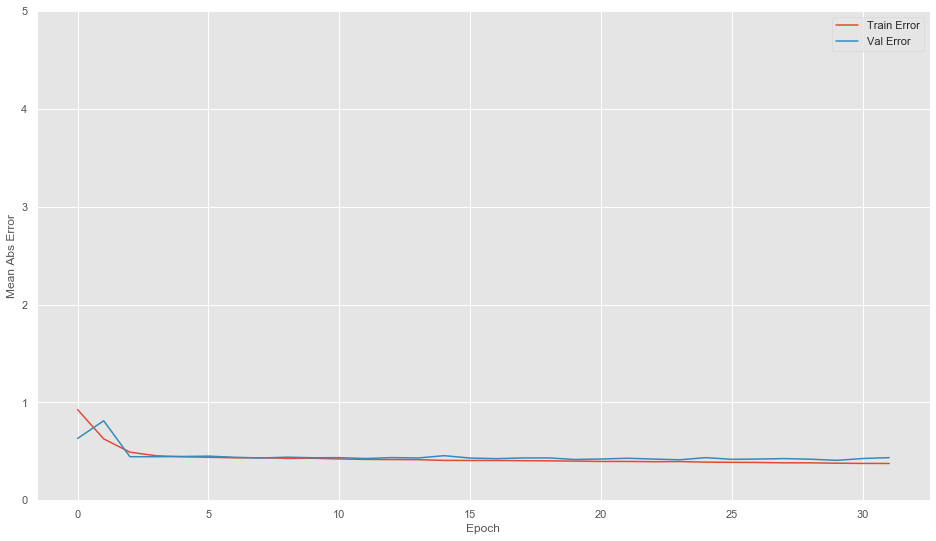

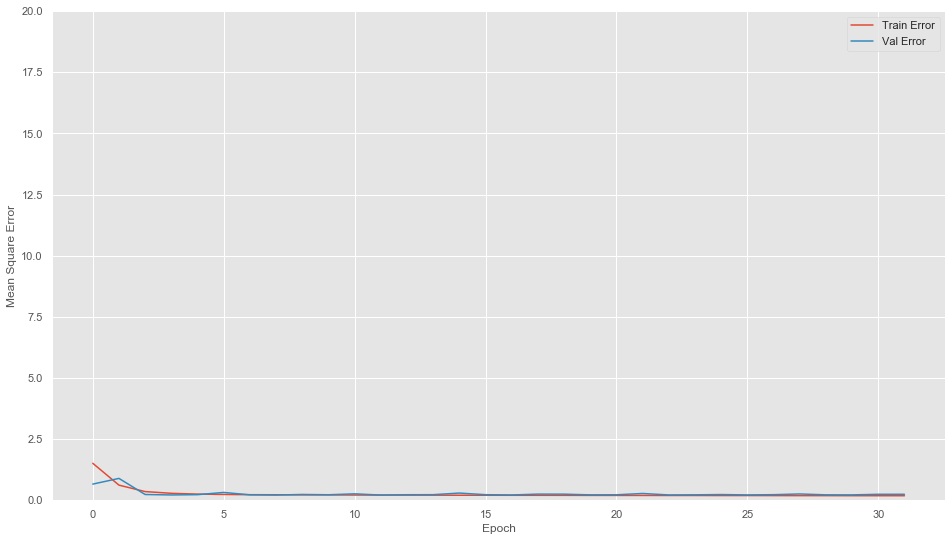

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [33]:
preds = model.predict(np.asarray(test_set)).round()
result['target'] = preds
print(F1(result))


0.6143465909090909


## TF-IDF

In [78]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag', C=10)
classifier.fit(train_set, train_label)

LogisticRegression(C=10, solver='sag')

In [79]:
preds = classifier.predict(test_set)
result['target'] = preds
print(F1(result))

0.49274160099543757


In [35]:
#NO EJECUTAR ESTA CELDA SALVO NESESIDAD DE ACTUALIZAR LAS PALABRAS IMPORTANTES
importancia = rf.feature_importances_
cols = test_set.columns
#dataImportacia = pd.DataFrame(columns=('importacia', 'col'))
#dataImportacia['importacia'] = importancia
#dataImportacia['col'] = cols
#dataImportacia = dataImportacia[dataImportacia['importacia'] > 0.001]
#dataImportacia.to_csv('impotacia.csv', index=False)#linea bloqueada por las dudas
cantidadImportantes = 0
for i in range(len(cols)):
    if (importancia[i] < 0.001):
        continue
    print(importancia[i],cols[i])
    cantidadImportantes += 1
print(cantidadImportantes,len(cols))
#dataImportacia.head()

0.2390805634162692 longitud_de_texto
0.10356755451085793 longitud_de_keyword
0.1495785422543723 cantidad_de_palabras_texto
0.00237350375031132 cantidad_de_palabras_keyword
0.04685193773478123 cantidad_de_hashtag_en_texto
0.004982539313145062 letra_0
0.003926678582109837 letra_1
0.004440598419622883 letra_2
0.005233410028750109 letra_3
0.0027622963481758874 earthquake
0.002358470515813103 everyone
0.0016901006666783641 street
0.001392154803011899 hey
0.00214993673194334 im
0.001033612848961267 song
0.0013459283696241483 traffic
0.002461013186582841 black
0.0033705876530110736 injured
0.001626441965061608 week
0.0012977403101263724 fall
0.001594919807935172 far
0.0010876019596148874 history
0.0010840221701216746 hard
0.002529627304767267 lol
0.0016005423181616816 fan
0.002106555365330004 god
0.0027767866723538053 air
0.0014003068324652227 island
0.0020361721529647578 times
0.007302318866651086 train
0.001051999048052131 die
0.0018248692018590466 change
0.0015764677032969036 latest
0.0015

## ENTREGA

In [31]:
resultado_final = result#varia segun el metodo
#resultado_final.columns = ['id','target']
#resultado_final.reset_index()
resultado_final.head()

,target
id,
0,0.00
2,1.00
3,1.00
9,0.00
11,1.00


In [32]:
#cuando todo termina el archivo de entrega
resultado_final.to_csv('submit.csv', index=False)